# Data-Science at Suburbia
At Suburbia we have been working extensively with transaction data generated from point-of-sales(pos) systems located in shops, bars, restaurants and sports-clubs. This notebook serves to explain some of the work we have been doing with data, including data quality, labelling and more. For this notebook we will focus on data from bars and restaurants, regarding so called Consumer Packaged Goods (CPG) or Fast Moving Consumer Goods (FMCG) 




## TOC
Table of Contents
1. [Suburbia](#Suburbia) 
    * Acquiring
    * Combining
    * Cleaning
    * Enriching
    * Distributing
    * Data-Science
2. [Data](#Data)
    * Input data
    * Processed data
        * Rule-based mapping
        * Human-labeling
        * Handling new or unlabeled data
        * Measuring mapping performance using yield
        * Measuring yield for brands
        * Other yield metrics
        * Drawbacks of this approach
    * Unbranded tagger
3. [Data_Quality](#Data_Quality) 
    * Problems
        * Problem 1
        * Problem 2
        * Problem 3
        * Problem 4
    * Automated Outlier Detection
    * Unbranded tagger
4. ToDo
    1. Simulating Suburbia's data
    2. Drawing conclusions: merchant stability
    3. Spell checking menue items
 

# [Suburbia](#TOC)
Suburbia acquires data from various sources which is combined, cleaned, enriched, and distributed to its customers. The aim of acquiring this data is to show economic activity by a sector, region or brand. Suburbia is interested in the Where, When and What, but never in the Who. Personal information is therefore not acquired not processed. 

## Acquiring
In particular for CPG data the data is acquired from various POS systems that are used in bars and restaurants. This data includes an date and time, the anonymized merchant, the location, a decription of the item sold and their value. The number of transactions covered runs in the Billions.

## Combining
Once the data is acquired, it is restructured in a canonical form that is used for all data that will be combined into a product. This means that for each final product a canonical form is defined, (one for cpg, one for luxury cosmetics, one for wholesale, one for financial transactions etc.). The end result is data that is all structured in a similar way, such that all further processing can be done in a generic way. Any data-source specific code is part of the combining step.

## Cleaning
Cleaning entails a large part of the processing effort, this part involves mapping the now structured data to meaningful data. As you can imagine in bars and cafe's there are many ways to indicate the same product. "coca-cola, c-cola, cola: cc-classic, can of coke" are but a few ways that coca-cola can be described. Furthermore, brands such as coca-cola have sub-brands "cherry-coke, coke-zero etc." which complicates things further. The kinds of meaningful data that we have extracted
* Brand
* Company of the brand
* Category (as tags or hierarchies)
* Location(in a canonical form)
A multitude of strategies have been used and explored including:
* Manual labeling
* Rule based labeling
* Natural Language Processing

## Enriching
Now that the data is structured and cleaned enriching is a relatively simple process of joining multiple datasets, for instance:
* location data with demographics
* date and time with weather data
* company with stock-prices

## Distributing
The data is now almost ready to ship to the customer but a few steps have to be taken to tailor the data to their needs. The data is far too big for certain customers and the tools they are used to such as excel, therefore the data needs to be pre-aggregated. More importanlty, to draw conclusions from the data first a stable subsection of the data needs to be created. The fact that a product has increased or decreased sales, in the dataset, is not enough to draw the conclusion that their sales have increased. For instance, if more merchants start using the POS systems more sales end up in our dataset, this does not mean there are more sales outside of the dataset.

## Data-Science 
We have put the most data-cience effort in the Cleaning, and Distributing of these described steps, together with the (data)quality control over the whole process. 

# [Data](#TOC)
We will further explain the data based on simulated data.

In [1]:
#!pip install ../

In [2]:
from analytics import merchant_stability, outlier_detection, unbranded_tagger, datasim
import numpy as np

Importing plotly failed. Interactive plots will not work.


In [3]:
np.random.seed(seed=1)

## Input data
We start with fictive data from 2 data sources A & B that contains 5 merchants, their location and the items they sell and their price. 

In [4]:
example = datasim.get_example_merchants()
example

[{'merchant': 'merchant_1',
  'data_source': 'A',
  'location': 'DE',
  'items': [('flasche heineken bier 0.5', 4),
   ('coca-cola', 3),
   ('pizza', 12),
   ('tee mit milch', 1),
   ('milch', 3)]},
 {'merchant': 'merchant_2',
  'data_source': 'A',
  'location': 'DE',
  'items': [('bier klein', 3),
   ('kaffee mit milch', 1),
   ('kaffee mit sucker', 9),
   ('tee mit sucker', 1)]},
 {'merchant': 'merchant_3',
  'data_source': 'B',
  'location': 'NL',
  'items': [('alcoholvrijbier', 5),
   ('bepsi-cola', 2),
   ('fles wijn', 25),
   ('rode wijn', 8)]},
 {'merchant': 'merchant_4',
  'data_source': 'B',
  'location': 'NL',
  'items': [('cola can', 5), ('pizza margeritha', 9), ('fles witte', 5)]},
 {'merchant': 'merchant_5',
  'data_source': 'B',
  'location': 'BE',
  'items': [('friet', 6), ('bier stella', 7), ('witte wijn', 1)]}]

We use the fictive data from above as a basis to create a dataset, as if it was acquired and ingested. The fields have the following meaning:
* date is the date that the transaction happend
* reporting_date, since there can be a delay between the transaction date and the date the data gets delivered. The reportingdate indicates when the data has been received.
* batch is the batch or batch-date on which the delivered data was processed.
* data_source is one of the POS systems that delivers data.
* merchant is the name of the merchant as described before
* location is the location as described before
* receipt_id, many lines together make a receipt such as 2 cola, 1 hamburger is one receipt but 2 lines
* line_id, a unique identifier for each line originally supplied by the POS system
* item, a description of the item as discussed before
* unit_price, the price of a single item as discussed before
* quantity, the number of items sold e.g. 2 for 2 cola
* volume_eur, the total euro value for that line = unit_price * quantity

In [5]:
indf = datasim.create_cpg_input_df(example)
indf.head(5)

,date,reporting_date,batch,data_source,merchant,location,receipt_id,line_id,item,unit_price,quantity,volume_eur
0,1,2,7,A,merchant_1,DE,1_merchant_1_145,0,flasche heineken bier 0.5,4,2,8
1,1,2,7,A,merchant_1,DE,1_merchant_1_217,1,flasche heineken bier 0.5,4,1,4
2,1,2,7,A,merchant_1,DE,1_merchant_1_56,2,flasche heineken bier 0.5,4,1,4
3,1,2,7,A,merchant_1,DE,1_merchant_1_126,3,flasche heineken bier 0.5,4,1,4
4,1,2,7,A,merchant_1,DE,1_merchant_1_174,4,flasche heineken bier 0.5,4,1,4


Let's have a look what this data looks like. We plot the date against total aggregates of the number of rows, the sales volume_eur and the number of items sold. There are clear peaks and valleys or seasonality representing the normal weekdays vs. the weekends. The Netherlands usually has the peak on Thursday,Friday,Saturday. While Germany has their peak a day later, Friday, Saturday, Sunday. You can think of it as the start of the series is a Monday, which is a slow day, together, with Tuesday and Wednesday, Thursday things start picking up, with the peak on Friday and Saturday, on sunday activity drops again.

Besides the scaling there is not much difference between the 3 graphs. However, we feel that first graphs which describes the number of rows is the most robust. Both volume_eur and quantity can be skewed by bad input data, highly priced items or by a issue with for instance currency conversion. We will therefore continue using the number of rows as our main graph, but it should be noted that the 3 graphs not showing the same behavior is an indication of data quality issues.

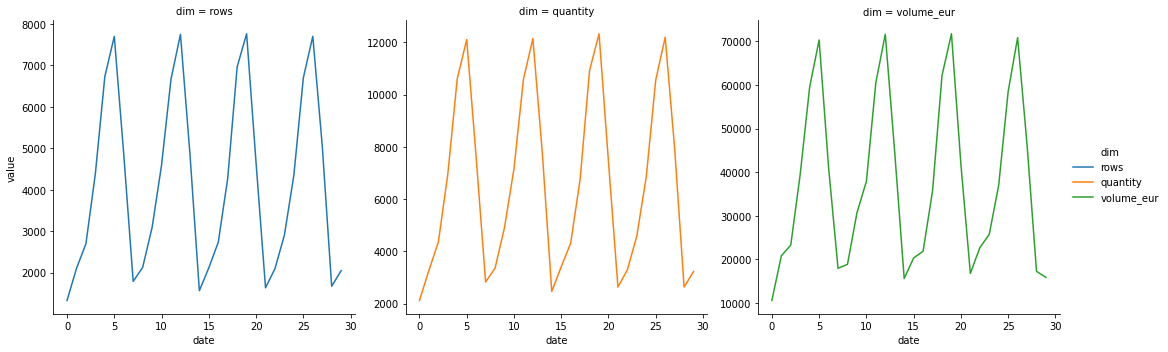

In [6]:
datasim.plot_data(indf, ['date'], ['rows', 'quantity', 'volume_eur'])

## Processed data
We saw the input data, this needs to be enriched to map the items to more meaningful data. The items are in various languages with typo's (bepsi) and abbrevations. 
### Rule-based mapping
We will use a simple mapping based on regex where we map
common words to their canonical English form. First as categories and later as brandnames of the items.

In [7]:
cat_map = datasim.get_example_category_map()
cat_map

{'bier': 'drinks/beer',
 'cola': 'drinks/cola',
 'friet': 'food/fries',
 'hamburger': 'food/hamburger',
 'kaffee': 'drinks/coffee',
 'pizza': 'food/pizza',
 'tee': 'drinks/tea'}

In this case we have a (regex-search) rule based mapping, but in reality such a mapping can also come from different sources such as human data-labelers, or automated labeling tools. To be able to combine multiple mappings, the mapping is fully materialized such that all different labeling/mapping sources can be combined. 


In [8]:
expanded_cat_map = datasim.expand_map(cat_map, indf['item'].unique())
expanded_cat_map

{'flasche heineken bier 0.5': 'drinks/beer',
 'bier klein': 'drinks/beer',
 'alcoholvrijbier': 'drinks/beer',
 'bier stella': 'drinks/beer',
 'coca-cola': 'drinks/cola',
 'bepsi-cola': 'drinks/cola',
 'cola can': 'drinks/cola',
 'friet': 'food/fries',
 'kaffee mit milch': 'drinks/coffee',
 'kaffee mit sucker': 'drinks/coffee',
 'pizza': 'food/pizza',
 'pizza margeritha': 'food/pizza',
 'tee mit milch': 'drinks/tea',
 'tee mit sucker': 'drinks/tea'}

### Human-labeling
Here a human labeler has reclassified alcoholfree beer as a carbonated drink. Therefore, this is manually added to the expanded mapping. We do this here for demonstration purposes, but drop this manual change later in the notebook.

In [9]:
expanded_cat_map['alcoholvrijbier'] = 'drinks/carbonated'
expanded_cat_map

{'flasche heineken bier 0.5': 'drinks/beer',
 'bier klein': 'drinks/beer',
 'alcoholvrijbier': 'drinks/carbonated',
 'bier stella': 'drinks/beer',
 'coca-cola': 'drinks/cola',
 'bepsi-cola': 'drinks/cola',
 'cola can': 'drinks/cola',
 'friet': 'food/fries',
 'kaffee mit milch': 'drinks/coffee',
 'kaffee mit sucker': 'drinks/coffee',
 'pizza': 'food/pizza',
 'pizza margeritha': 'food/pizza',
 'tee mit milch': 'drinks/tea',
 'tee mit sucker': 'drinks/tea'}

### Handling new or unlabeled data
The next step is to map the original items using this expanded_mapping, using pandas DataFrame.map. We show the unique categories that got mapped, this also shows that we handle data that is not in the previous mapping such as new or unlabeled data as a new category 'unknown', the catch-all for items that match no mapping. 

In [10]:
indf['item'].map(expanded_cat_map).fillna("unknown").unique()

array(['drinks/beer', 'drinks/cola', 'food/pizza', 'drinks/tea',
       'unknown', 'drinks/coffee', 'drinks/carbonated', 'food/fries'],
      dtype=object)

We repeat the steps above for the mapping from items to brands, to create a mapping expand it and enrich the data by mapping the items to brands. Finally we show what all the mappings look like.

In [11]:
brand_map = datasim.get_example_brand_map()
expanded_brand_map = datasim.expand_map(brand_map, indf['item'].unique())
processed = datasim.clean_data(indf, expanded_cat_map, expanded_brand_map)
processed[['item', 'brand', 'category']].drop_duplicates()

,item,brand,category
0,flasche heineken bier 0.5,heineken,drinks/beer
8059,coca-cola,coca-cola,drinks/cola
15413,pizza,unbranded,food/pizza
22593,tee mit milch,unbranded,drinks/tea
28884,milch,unknown,unknown
36924,bier klein,unknown,drinks/beer
43390,kaffee mit milch,unknown,drinks/coffee
47789,kaffee mit sucker,unbranded,drinks/coffee
52980,tee mit sucker,unbranded,drinks/tea
58826,alcoholvrijbier,unknown,drinks/carbonated


### Measuring mapping performance using yield
To make monitor the performance of the labeling and mapping efforts the simple metric of what we call the labeling yield. Simply put, what's the percentage of unlabeled rows of data after processing or items mapped to 'unknown'.

In [12]:
yield_cat = processed[processed['category'] != 'unknown'].count()[0]/processed.count()[0]
print("The category yield is: {0:.2%}".format(yield_cat))    

The category yield is: 70.06%


This yield of about 70% is not bad, but looking at the processed data above, we see that we did not label things with wijn as a category, so we will again add this mapping/label by hand and look if the yield improves. 

In [13]:
expanded_cat_map['wijn']='drinks/wine'
processed1 = datasim.clean_data(indf, expanded_cat_map, expanded_brand_map)
yield_cat = processed1[processed1['category'] != 'unknown'].count()[0]/processed1.count()[0]
print("The category yield is: {0:.2%}".format(yield_cat))  

The category yield is: 70.06%


How is this possible? we added the a mapping and our yield did not improve? The problem here is that we made a rule 
wijn -> drinks/wine. This should not have be added to the expanded map, but to the original (regex)-rule based mapping, as shown below. We improve to about 87% with the addition of one rule. Using yield as a metric, it makes sense to focus the labeling effort on the highest yielding unique items. 

In [14]:
cat_map['wijn']='drinks/wine'
expanded_cat_map = datasim.expand_map(cat_map, indf['item'].unique())
processed2 = datasim.clean_data(indf, expanded_cat_map, expanded_brand_map)
yield_cat = processed2[processed2['category'] != 'unknown'].count()[0]/processed2.count()[0]
print("The category yield is: {0:.2%}".format(yield_cat)) 

The category yield is: 87.02%


### Measuring yield for brands
For brands we follow the same strategy as for categories, but many items sold do not contain brands: cola, tea, hamburger are all unbranded items. Therefore, it is important to track the yield of the "branded" items, the "unbranded" items and the unlabeled/unmapped/"unknown" items, to keep track of the labeling effort.

In [15]:
yield_brand = (processed[processed['brand'] != 'unknown'].count()[0]/processed.count()[0])
yield_unbranded = (processed[processed['brand'] == 'unbranded'].count()[0]/processed.count()[0])
#yield_heineken = (processed[processed['brand'] == 'unknown'].count()[0]/processed.count()[0])
print("The brand yield is: {0:.2%}, this includes {1:.2%} for unbranded items.".format(yield_brand, yield_unbranded))

The brand yield is: 56.67%, this includes 36.37% for unbranded items.


In the next part about the unbranded tagger, we will automate the yield for unbranded items, and therfore the yield for brands in total. 

### Other yield metrics
Here we used yield based on the percentage of rows, but other defenitions of yield can be beneficial such as: 
* yield of number of rows (as discussed above)
* yield of number of unique rows ( usually the data is skewed, common items such as cola, beer, tea, coffee are often in the data thus one rule for cola has a high number of rows yield, but a number of unique rows yield of 1. This makes a good metric for tracking the (human) data-labeling effort.)
* yield of volume or quantity, what is the percentage of items sold that you are tracking and what is the sales volume what you are tracking. These are good definitions of yield for commercial/business purposes.

### Drawbacks of this approach
One of the drawbacks of creating a full map is that any new items that have not been seen before will not be in the full expanded mapping, eventhough there might be a rule that would match. It is therfore important to often refresh the full map with new items.
Drawbacks of categorization in a hierarchy are can be seen byby aloholfree-beer or iced-coffee making hierarchies such as alcoholic/beer or hot-drinks/coffee difficult. Tags could be used instead but have the problem of not being able to generalize to a higher category.

## Unbranded tagger
With the unbranded tagger/mapper/labeler we automatically find words in the menu item descriptions that have only been used with other unbranded items. If a description of a menu item only contains words used with other unbranded items, we label the item as unbranded. The aim is to improve the yield for unbranded items.  

In [16]:
unbranded = processed.loc[processed['brand'] == 'unbranded', 'item'].drop_duplicates()
unknown = processed.loc[processed['brand'] == 'unknown', 'item'].drop_duplicates()
print("All unbranded items:\n{0}\n{1}\n".format("_"*20, "\n".join(list(unbranded))))
print("All unknown items:\n{0}\n{1}\n".format("_"*18, "\n".join(list(unknown))))

to_label_unbranded = unbranded_tagger.get_unbranded(
    to_label=unknown,
    unbranded=unbranded,
    tokens_to_exclude=['red', 'bull'],  # for brands comprised of common words 
    min_unbranded_rows=1,
)
print('Items labeled as "unbranded":\n{}'.format("_"*29))
for item in unknown[to_label_unbranded]:
    print(item)

All unbranded items:
____________________
pizza
tee mit milch
kaffee mit sucker
tee mit sucker
rode wijn
pizza margeritha
fles witte

All unknown items:
__________________
milch
bier klein
kaffee mit milch
alcoholvrijbier
bepsi-cola
fles wijn
cola can
friet
witte wijn

Items labeled as "unbranded":
_____________________________
milch
kaffee mit milch
fles wijn
witte wijn


The unbranded-tagger has found 4 items that we could have labeled as unbranded since all their words have only been used with other unbranded items. We we will add them to our expanded_brand_map, since this is a mapping from item description -> brand. We see an improvement in branded yield from 57% to 77%, all due to more unbranded mappings.

In [17]:
for item in unknown[to_label_unbranded]:
    expanded_brand_map[item]='unbranded'
processed3 = datasim.clean_data(indf, expanded_cat_map, expanded_brand_map)
yield_brand = (processed3[processed3['brand'] != 'unknown'].count()[0]/processed3.count()[0])
yield_unbranded = (processed3[processed3['brand'] == 'unbranded'].count()[0]/processed3.count()[0])
#yield_heineken = (processed[processed['brand'] == 'unknown'].count()[0]/processed.count()[0])
print("The brand yield is: {0:.2%}, this includes {1:.2%} for unbranded items.".format(yield_brand, yield_unbranded))

The brand yield is: 76.79%, this includes 56.49% for unbranded items.


# [Data_Quality](#TOC)

Data Quality, or what could go wrong? We have shown how our main process for cleaning data works. In this section  we will show some problems that we have encountered in input data or or with processing data, and how we have monitored for data quality. 

## Problems
We will start looking at data quality by simulating issues that we have encountered in the past. As a reference, we start with the dataframe we produced in the last section and visualize the brands over time. As discussed in the section about input data, we will limit our visualization to only the rows dimension, to simplify things.

### Strategy
The Strategy we have for identifying problems is always of the form
1. Proccess Data, to replicate any errors through the whole processing pipeline 
2. Visualize Data, visualize the data to see any anomalies
3. Investigate, once something suspicious is found investigate
4. Resolve, once the issue has been identified, resolve the issue

In the last section we will automate part of this process, but visualisation is a good place to start. Furthermore in the examples we will see, we only pick limited visualizations to look at, but since anomalies can occur anywhere, for spotting anomalies all visualisations have to be checked to make sure the processed data is of the desired quality.


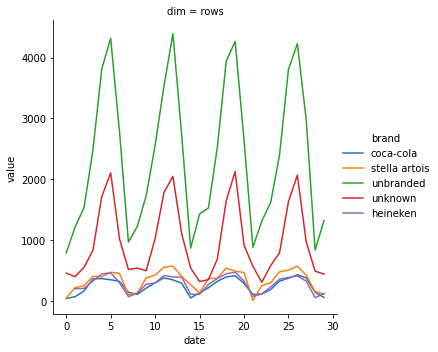

In [18]:
datasim.plot_data(processed3, ['date', 'brand'], ['rows'])

## Problem 1
We start with problem 1 which we first create from our simulated input data. We process the data as before and look at the result. At first sight everything looks ok, lets dig a bit deeper.

We see a large spike of unbranded items, this indicates a problem with the cleaning stages of the processing, since unbranded is used when no mapping is found.

##### TODO (known bug)
The chosen graph doesn't plot missing data as 0, but connects between known points, which shows branded that is too high.

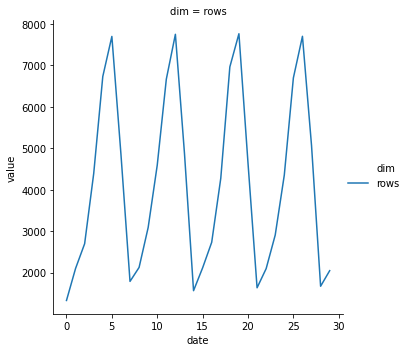

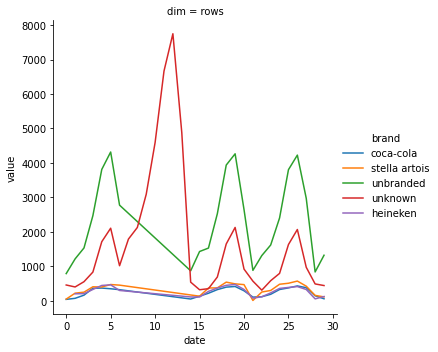

In [19]:
df_p1 = datasim.problem1(indf)
processed_p1 = datasim.clean_data(df_p1, expanded_cat_map, expanded_brand_map)
datasim.plot_data(processed_p1, ['date'], ['rows'])
datasim.plot_data(processed_p1, ['date', 'brand'], ['rows'])

### Investigate 1
When we look at the unique items in the input date the problem is clear. The data for one of the batches has changed, everything is all uppercase and therefore none of our mapping worked. Inreality uppercase could be any unforseen change in input data for items by the data source, which would lead to a reduced mapping of from items to brands or categories

In [20]:
processed_p1['item'].unique()

array(['flasche heineken bier 0.5', 'FLASCHE HEINEKEN BIER 0.5',
       'coca-cola', 'COCA-COLA', 'pizza', 'PIZZA', 'tee mit milch',
       'TEE MIT MILCH', 'milch', 'MILCH', 'bier klein', 'BIER KLEIN',
       'kaffee mit milch', 'KAFFEE MIT MILCH', 'kaffee mit sucker',
       'KAFFEE MIT SUCKER', 'tee mit sucker', 'TEE MIT SUCKER',
       'alcoholvrijbier', 'ALCOHOLVRIJBIER', 'bepsi-cola', 'BEPSI-COLA',
       'fles wijn', 'FLES WIJN', 'rode wijn', 'RODE WIJN', 'cola can',
       'COLA CAN', 'pizza margeritha', 'PIZZA MARGERITHA', 'fles witte',
       'FLES WITTE', 'friet', 'FRIET', 'bier stella', 'BIER STELLA',
       'witte wijn', 'WITTE WIJN'], dtype=object)

### Resolution 1
Look at changes in the processsing pipeline for the cause or otherwise it is a change in input data, which should be solved at the data source.

## Problem 2
Problem 2 is created from our simulated input data. We process the data as before and look at the result. At first sight we see a small reduction in one of the peaks, but this could also be because of a random influence such as bad weather or a national holiday. 

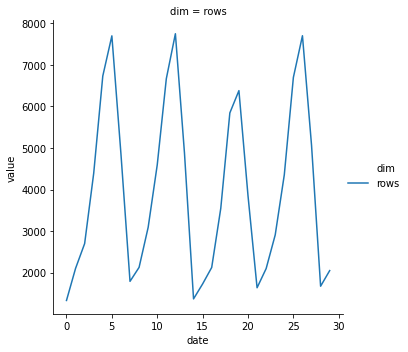

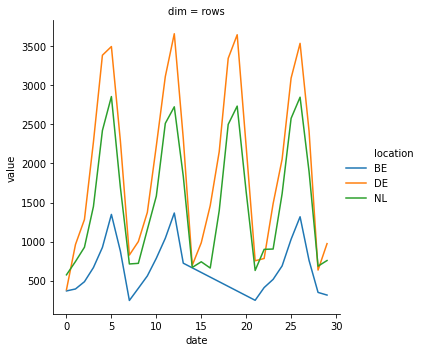

In [21]:
df_p2 = datasim.problem2(indf)
processed_p2 = datasim.clean_data(df_p2, expanded_cat_map, expanded_brand_map)
datasim.plot_data(processed_p2, ['date'], ['rows'])
datasim.plot_data(processed_p2, ['date', 'location'], ['rows'])

### Investigate 2
We dig a bit deeper and look at the rows: location and the problem becomes clear. We see that the batch that ran on day 21 does not have any data for "BE". Missing data based on geography is quite common since different locations can be served by different systems at the data provider. 

In [22]:
processed_p2=processed_p2.assign(location=lambda d: d['location'].astype('category'))
processed_p2.groupby(['batch', 'location'])['location'].count()

batch  location
7      BE           5070
       DE          14073
       NL          10669
14     BE           5131
       DE          14520
       NL          11248
21     BE              0
       DE          14502
       NL          10341
28     BE           4974
       DE          14121
       NL          11370
35     BE            666
       DE           1610
       NL           1444
Name: location, dtype: int64

### Resolution 2

Ask the data source for the missing data, and make sure your own processing pipeline is not dropping this specific data.

## Problem 3
Problem 3 is created from our simulated input data. We immediately see a peak, this looks like too much data.

Zooming in to see the different batches we see an extra batch 42 for data from the first week. 

Last, when we look at the data sources, we see that data source "A" is the only one with a peak.

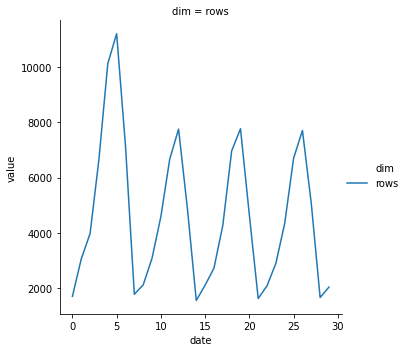

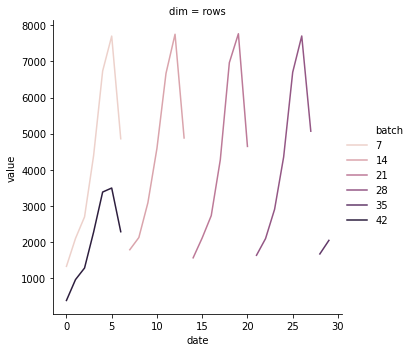

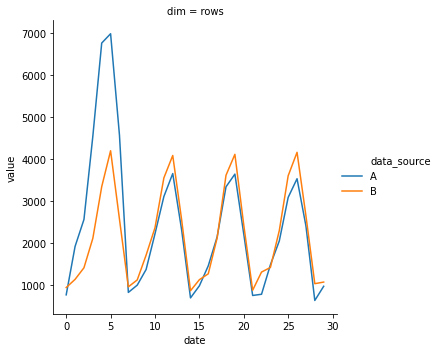

In [23]:
df_p3 = datasim.problem3(indf)
processed_p3 = datasim.clean_data(df_p3, expanded_cat_map, expanded_brand_map)
datasim.plot_data(processed_p3, ['date'], ['rows'])
datasim.plot_data(processed_p3, ['date', 'batch'], ['rows'])
datasim.plot_data(processed_p3, ['date', 'data_source'], ['rows'])

### Investigate 3
We get a unique identifier from our data sources "line_id". We will use that to investigate if there are duplicates.
It looks like we have duplicates, we have a look if one of the batches is duplicated and we see that batch 7 and 42 are exactly the same row.

In [24]:
print("The total number of lines is:{0}".format(df_p3["line_id"].count()))
print("The total number of unique lines is:{0}".format(df_p3["line_id"].nunique()))
print("The difference is:{0}".format(df_p3["line_id"].count()-df_p3["line_id"].nunique()))

df_p3[df_p3['data_source']=='A'].groupby(['batch'])['batch'].count()

The total number of lines is:139035
The total number of unique lines is:124962
The difference is:14073


batch
7     14073
14    14520
21    14502
28    14121
35     1610
42    14073
Name: batch, dtype: int64

### Resolution 3
There was an extra batch at date 42 that reprosessed data already processed on date 7. Either the data source re-uploaded old data to make a fix or for some other purpose data was processed twice. Make sure to choose the correct data and process data without duplicate input data. 

## Problem 4
We again see a peak similar to what we saw in problem 3, this again looks like too much data.

Zooming in to see the different batches we again see the extra batch 42.

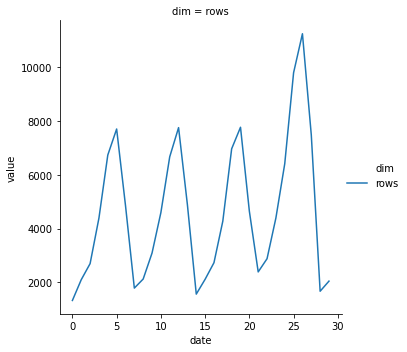

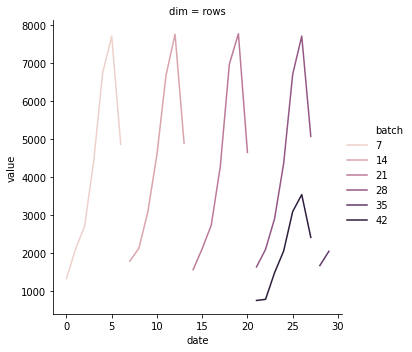

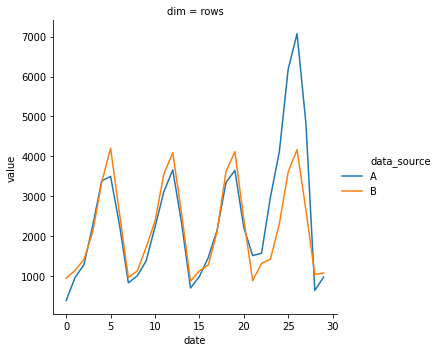

In [206]:
df_p4 = datasim.problem4(indf)
processed_p4 = datasim.clean_data(df_p4, expanded_cat_map, expanded_brand_map)
datasim.plot_data(processed_p4, ['date'], ['rows'])
datasim.plot_data(processed_p4, ['date', 'batch'], ['rows'])
datasim.plot_data(processed_p4, ['date', 'data_source'], ['rows'])

### Investigate 4

We proceed as before and search for duplicate line_id's; unfortunately no duplicate lines are found. 
We therefore pick one of the dates to have a look at and see indeed duplicate lines with different line_id's

In [28]:
print("The total number of lines is:{0}".format(df_p4["line_id"].count()))
print("The total number of unique lines is:{0}".format(df_p4["line_id"].nunique()))
print("The difference is:{0}".format(df_p4["line_id"].count()-df_p4["line_id"].nunique()))

df_p4[(df_p4['date']==25) & (df_p4['data_source']=='A')].sort_values(by='receipt_id').head(10)

The total number of lines is:139083
The total number of unique lines is:139083
The difference is:0


,index,date,reporting_date,batch,data_source,merchant,location,receipt_id,line_id,item,unit_price,quantity,volume_eur
21345,21345,25,26,28,A,merchant_1,DE,25_merchant_1_0,21345,pizza,12,1,12
129485,21345,25,26,42,A,merchant_1,DE,25_merchant_1_0,129485,pizza,12,1,12
125803,6834,25,26,42,A,merchant_1,DE,25_merchant_1_1,125803,flasche heineken bier 0.5,4,1,4
6834,6834,25,26,28,A,merchant_1,DE,25_merchant_1_1,6834,flasche heineken bier 0.5,4,1,4
129599,21459,25,26,42,A,merchant_1,DE,25_merchant_1_10,129599,pizza,12,1,12
21459,21459,25,26,28,A,merchant_1,DE,25_merchant_1_10,21459,pizza,12,1,12
6992,6992,25,26,28,A,merchant_1,DE,25_merchant_1_10,6992,flasche heineken bier 0.5,4,2,8
125961,6992,25,26,42,A,merchant_1,DE,25_merchant_1_10,125961,flasche heineken bier 0.5,4,2,8
6991,6991,25,26,28,A,merchant_1,DE,25_merchant_1_100,6991,flasche heineken bier 0.5,4,1,4
21384,21384,25,26,28,A,merchant_1,DE,25_merchant_1_100,21384,pizza,12,2,24


The next level of id's we can investigate is at the receipt level. If we have many duplicated items then we will see a low number of receipts of length 1 and many more with an even length since everything is duplicated. We will only look at data source 'A' since this is where the problem seems to be. For this we will first look at the number of lines in a receipt and then count how many receipts there are of length 1,2,3,4,... 

##### TODO (known bug)
potentially move all plotting into datasim, I also don't like the indentation

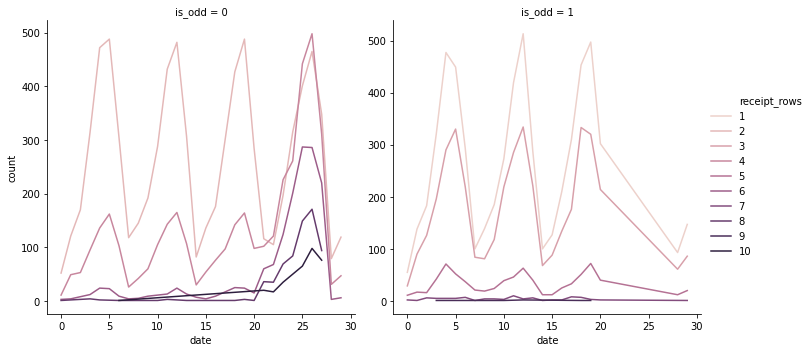

In [231]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

df_p4plot = df_p4[df_p4['data_source']=='A']
df_p4plot = df_p4plot.groupby(
                ['date', 'receipt_id']
            ).agg(
                is_odd=pd.NamedAgg(column='date', aggfunc=lambda x: x.count() % 2 ),
                receipt_rows=pd.NamedAgg(column='date', aggfunc='count')
            ).reset_index(
            ).assign(receipt_rows = lambda d: d['receipt_rows'].map(lambda r: r if r < 10 else 10)
            ).groupby(
                ['date',  'is_odd','receipt_rows']
            ).agg( count=pd.NamedAgg(column='date', aggfunc='count')
            ).reset_index()
sns.relplot(x='date', y='count',  hue='receipt_rows', col='is_odd',  kind='line',legend="full", facet_kws=dict(sharey=False),data=df4, estimator=None)
plt.show()

The plot shows that there are no receipts with an odd number of lines, while on the receipts with an een number of lines, we roughly see a doubeling. In reality where receipt_rows should be 1 it now is 2, 2->4 3->6 etc. This clearly indicates that only the line_id's were affected and not the receipt_id's

### Resolution 4
Luckily here everthing that was wrong was loaded in batch 42, if this was not the case it requires some inginuity to find out what duplicates are and what are not.

In any case, not getting proper id's from the data_source is a problem that should be resolved at the source.


# ToDo
### automated outlier detection
## generating simulated data
## drawing conclusions from data and merchant stability